In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

# === Load Data ===
labeled_df = pd.read_csv('labeled_thermal_features.csv')
unlabeled_df = pd.read_csv('thermal_frame_features.csv')

# === Select Top 5 Important Statistical Features ===
top_features = ["IQR", "Std_Temp", "Q1", "Min_Temp", "Median_Temp"]
X_labeled = labeled_df[top_features]
y_labeled = labeled_df["Porosity Label"]
X_unlabeled = unlabeled_df[top_features]

# === Normalize with MinMaxScaler ===
scaler = MinMaxScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# === Train on Normal Class Only (Semi-Supervised) ===
X_train = X_labeled_scaled[y_labeled == 0]

# === Initialize and Fit One-Class SVM ===
oc_svm = OneClassSVM(kernel='rbf', nu=0.035, gamma=0.05)
oc_svm.fit(X_train)

# === Predict on Labeled Set using Decision Scores ===
decision_scores = oc_svm.decision_function(X_labeled_scaled)
threshold = np.percentile(decision_scores, 3.5)  # Adjust percentile for best F1
pred_labeled = (decision_scores < threshold).astype(int)

# === Evaluation ===
conf_matrix = confusion_matrix(y_labeled, pred_labeled)
report = classification_report(y_labeled, pred_labeled)
f1 = f1_score(y_labeled, pred_labeled)
acc = accuracy_score(y_labeled, pred_labeled)

print("✅ One-Class SVM Evaluation (Top 5 Statistical Features):")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

# === Predict on Unlabeled Set ===
decision_scores_unlabeled = oc_svm.decision_function(X_unlabeled_scaled)
pred_unlabeled = (decision_scores_unlabeled < threshold).astype(int)

# === Save Predictions ===
unlabeled_df["SVM_Anomaly_Tuned"] = pred_unlabeled
unlabeled_df.to_csv("svm_tuned_predictions.csv", index=False)
print("📁 Predictions saved to 'svm_tuned_predictions.csv'")


✅ One-Class SVM Evaluation (Top 5 Statistical Features):
Confusion Matrix:
 [[1485    8]
 [  24   47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1493
           1       0.85      0.66      0.75        71

    accuracy                           0.98      1564
   macro avg       0.92      0.83      0.87      1564
weighted avg       0.98      0.98      0.98      1564

F1 Score: 0.7460
Accuracy: 0.9795
📁 Predictions saved to 'svm_tuned_predictions.csv'


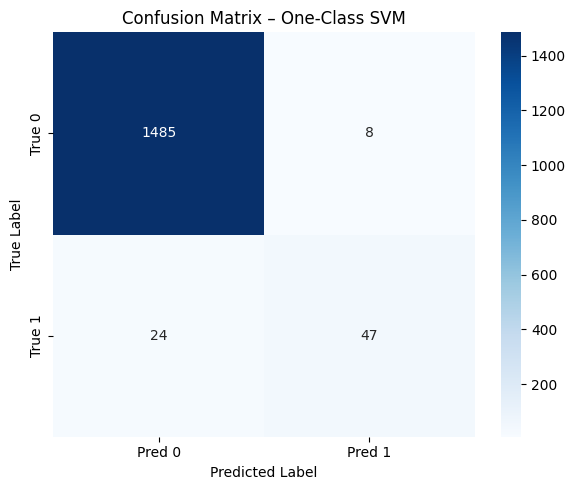

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_labeled, pred_labeled)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'])

plt.title("Confusion Matrix – One-Class SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
